# Twitter Sentiment Analysis (Natural Language Processing)

In [193]:
# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# set visualization style
sns.set(style="whitegrid")

# nltk imports
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/patndirangu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/patndirangu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/patndirangu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Loading and Inspection

In [119]:
# load the dataset
tweet_df = pd.read_csv('data/twitter_data.csv', encoding='latin-1')

# display the first few rows of the dataset
tweet_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [120]:
# check the dataset info
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [121]:
# rename the columns in the dataset
def rename_columns(df):
    df.columns = ['tweet', 'tweet_destination', 'sentiment']
    return df

tweet_df = rename_columns(tweet_df)
tweet_df.head()

,tweet,tweet_destination,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [122]:
# combine the 'No emotion toward brand or product' and 'No emotion toward brand or product' into a single category
tweet_df['sentiment'] = tweet_df['sentiment'].replace(
    {
        "No emotion toward brand or product": "Neutral",
        "I can't tell": "Neutral",
    }
)

# check the unique values in the sentiment column
print("Unique Sentiments:")
print(tweet_df['sentiment'].unique())

Unique Sentiments:
['Negative emotion' 'Positive emotion' 'Neutral']


In [123]:
# check for missing values
tweet_df.isna().sum()

tweet                   1
tweet_destination    5802
sentiment               0
dtype: int64

In [124]:
# check for duplicate values
tweet_df.duplicated().sum()

np.int64(22)

In [125]:
# use the simple imputer to fill missing values
imputer = SimpleImputer(strategy='most_frequent')
tweet_df[['tweet_destination']] = imputer.fit_transform(tweet_df[['tweet_destination']])

# drop the missing value in 'tweet' column
tweet_df.dropna(subset=['tweet'], inplace=True, axis=0)

# check again for missing values
tweet_df.isna().sum()

tweet                0
tweet_destination    0
sentiment            0
dtype: int64

In [126]:
# drop the duplicate rows
tweet_df.drop_duplicates(inplace=True)
tweet_df.duplicated().sum()

np.int64(0)

## EDA

In [127]:
# Basic dataset overview
print("Dataset Overview")
print("=" * 50)
print(f"Dataset shape: {tweet_df.shape}")
print(f"Number of tweets: {len(tweet_df)}")
print(f"Number of features: {len(tweet_df.columns)}")
print(f"Memory usage: {tweet_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nColumn Information:")
print("-" * 30)
for col in tweet_df.columns:
    print(f"• {col}: {tweet_df[col].dtype}")

print("\nDataset Info:")
tweet_df.info()

print("\nFirst few rows:")
tweet_df.head(10)

Dataset Overview
Dataset shape: (9070, 3)
Number of tweets: 9070
Number of features: 3
Memory usage: 2.45 MB

Column Information:
------------------------------
• tweet: object
• tweet_destination: object
• sentiment: object

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 9070 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   tweet              9070 non-null   object
 1   tweet_destination  9070 non-null   object
 2   sentiment          9070 non-null   object
dtypes: object(3)
memory usage: 283.4+ KB

First few rows:


,tweet,tweet_destination,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,iPad,Neutral
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion


In [128]:
# Sentiment Distribution Analysis
print("Sentiment Distribution Analysis")
print("=" * 40)

# Count unique sentiment values
sentiment_counts = tweet_df['sentiment'].value_counts()
print("Sentiment Categories:")
print(sentiment_counts)

# Calculate percentages
sentiment_percentages = tweet_df['sentiment'].value_counts(normalize=True) * 100
print("\nSentiment Distribution (%):")
print(sentiment_percentages.round(2))

Sentiment Distribution Analysis
Sentiment Categories:
sentiment
Neutral             5531
Positive emotion    2970
Negative emotion     569
Name: count, dtype: int64

Sentiment Distribution (%):
sentiment
Neutral             60.98
Positive emotion    32.75
Negative emotion     6.27
Name: proportion, dtype: float64


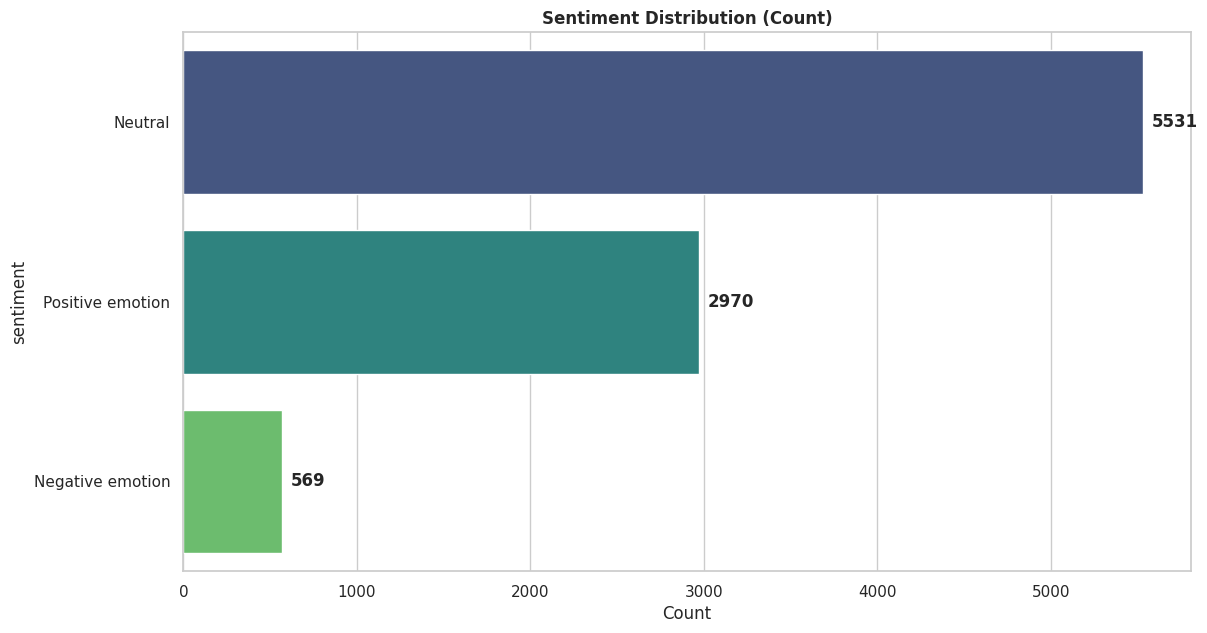

In [129]:
# Visualize sentiment distribution
plt.figure(figsize=(13, 7))

# Plot 1: Count plot
# plt.subplot(2, 3, 1)
ax = sns.countplot(data=tweet_df, y='sentiment', order=sentiment_counts.index, palette='viridis')
plt.title('Sentiment Distribution (Count)', fontsize=12, fontweight='bold')
plt.xlabel('Count')
for i, v in enumerate(sentiment_counts.values):
    ax.text(v + 50, i, str(v), va='center', fontweight='bold')

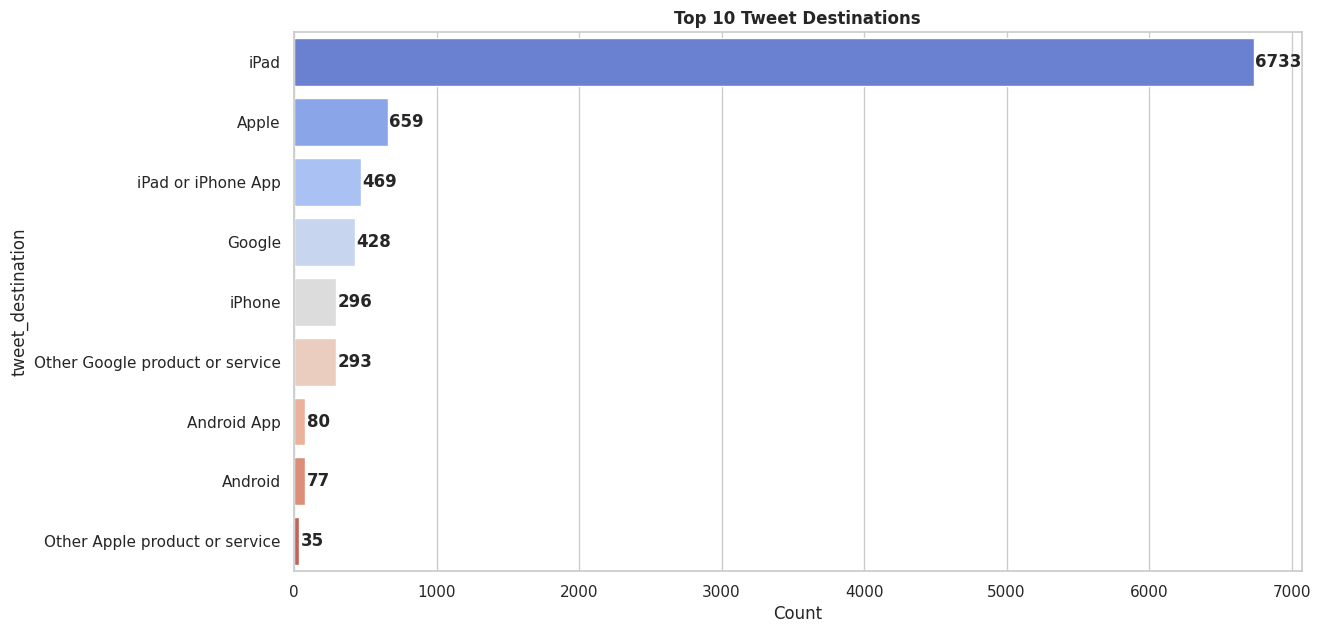

In [130]:
# Plot 2: Tweet destination distribution
plt.figure(figsize=(13, 7))
tweet_dest_counts = tweet_df['tweet_destination'].value_counts().head(10)
ax = sns.barplot(x=tweet_dest_counts.values, y=tweet_dest_counts.index, palette='coolwarm')
plt.title('Top 10 Tweet Destinations', fontsize=12, fontweight='bold')
plt.xlabel('Count')
for i, v in enumerate(tweet_dest_counts.values):
    ax.text(v + 10, i, str(v), va='center', fontweight='bold')

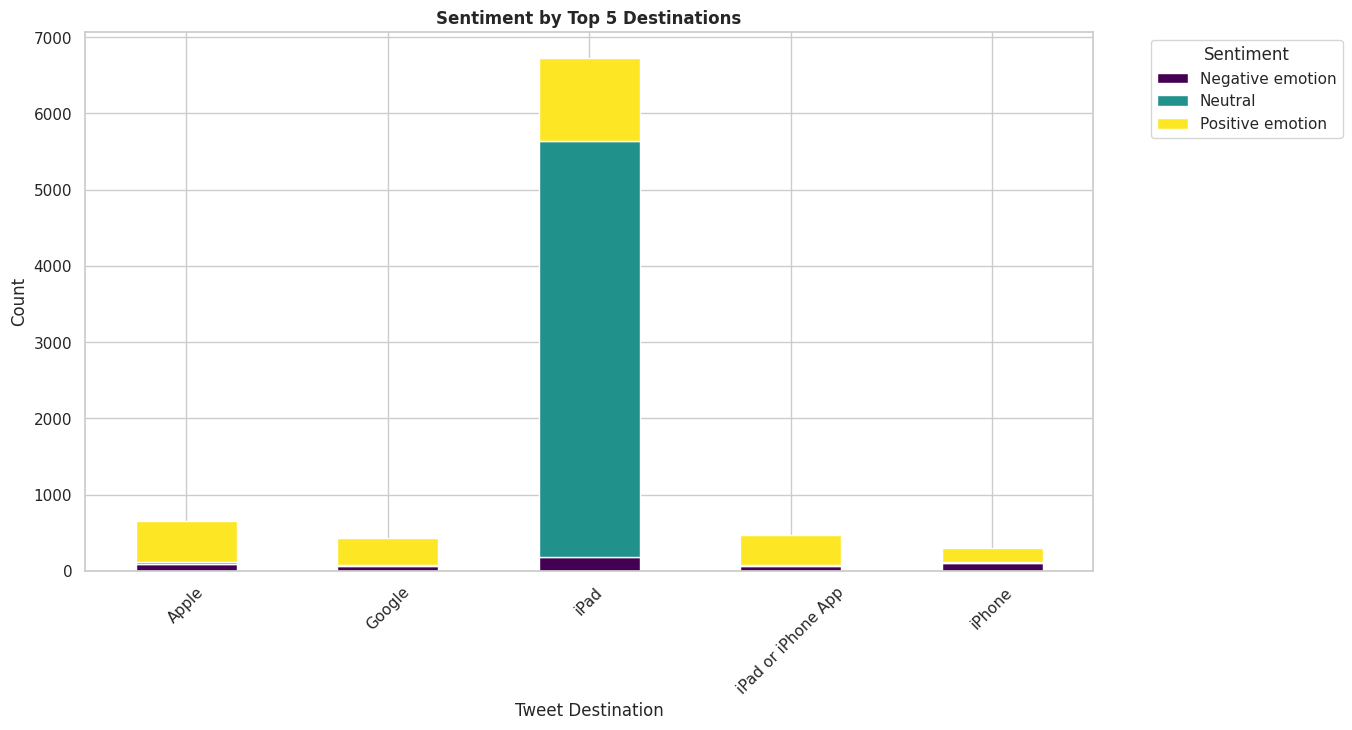

In [131]:
# Plot 4: Sentiment by tweet destination
plt.figure(figsize=(13, 7))
top_destinations = tweet_df['tweet_destination'].value_counts().head(5).index
filtered_df = tweet_df[tweet_df['tweet_destination'].isin(top_destinations)]
sentiment_dest = pd.crosstab(filtered_df['tweet_destination'], filtered_df['sentiment'])
sentiment_dest.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='viridis')
plt.title('Sentiment by Top 5 Destinations', fontsize=12, fontweight='bold')
plt.xlabel('Tweet Destination')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')

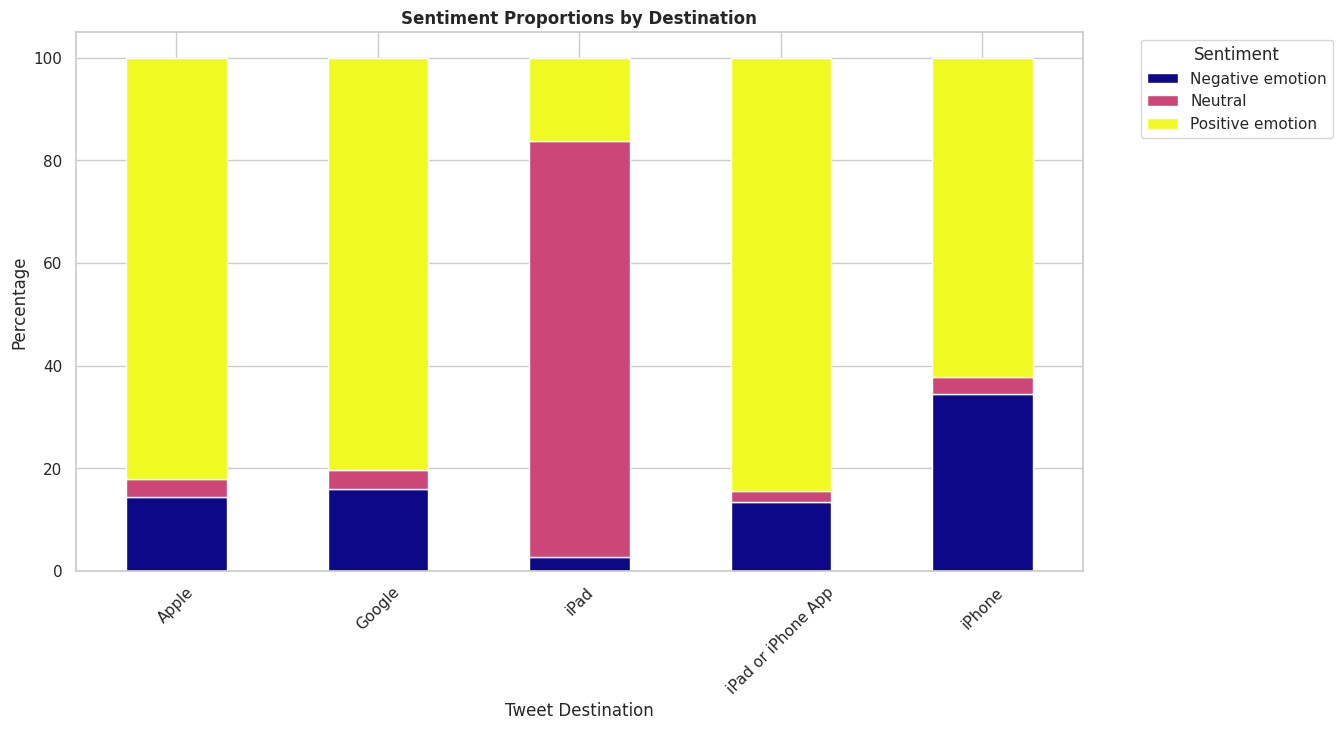

In [132]:
# Plot 5: Sentiment proportions by destination
plt.figure(figsize=(13, 7))
sentiment_dest_pct = pd.crosstab(filtered_df['tweet_destination'], 
                                filtered_df['sentiment'], normalize='index') * 100
sentiment_dest_pct.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='plasma')
plt.title('Sentiment Proportions by Destination', fontsize=12, fontweight='bold')
plt.xlabel('Tweet Destination')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')

([0, 1, 2],
 [Text(0, 0, 'Negative emotion'),
  Text(1, 0, 'Positive emotion'),
  Text(2, 0, 'Neutral')])

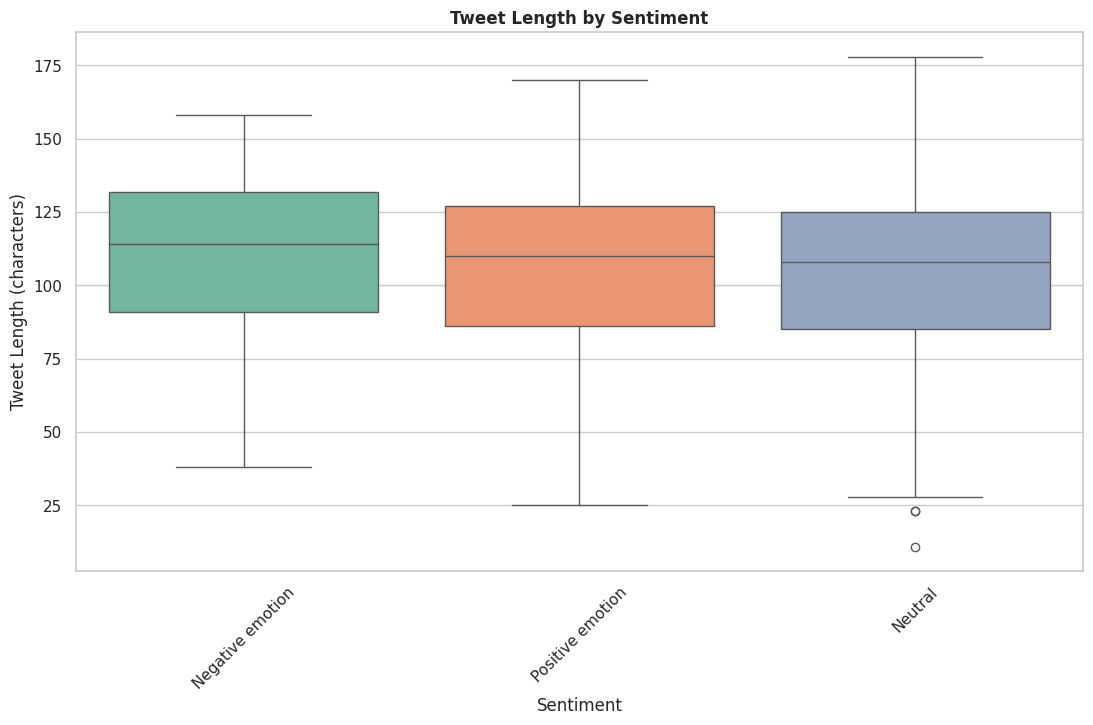

In [133]:
# Plot 6: Tweet length distribution by sentiment
plt.figure(figsize=(13, 7))
tweet_df['tweet_length'] = tweet_df['tweet'].str.len()
sns.boxplot(data=tweet_df, x='sentiment', y='tweet_length', palette='Set2')
plt.title('Tweet Length by Sentiment', fontsize=12, fontweight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Length (characters)')
plt.xticks(rotation=45)

In [134]:
# Basic text statistics
def generate_columns(df):
    df['chars'] = df['tweet'].apply(len)
    df['words'] = df['tweet'].apply(lambda x: nltk.word_tokenize(x)).apply(len)
    df['sentences'] = df['tweet'].apply(lambda x: nltk.sent_tokenize(x)).apply(len)
    return df
tweet_df = generate_columns(tweet_df)
tweet_df.head()

,tweet,tweet_destination,sentiment,tweet_length,chars,words,sentences
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,127,127,32,5
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,139,139,29,3
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,79,79,20,2
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,82,82,21,2
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,131,131,29,1


Text(0, 0.5, 'Frequency')

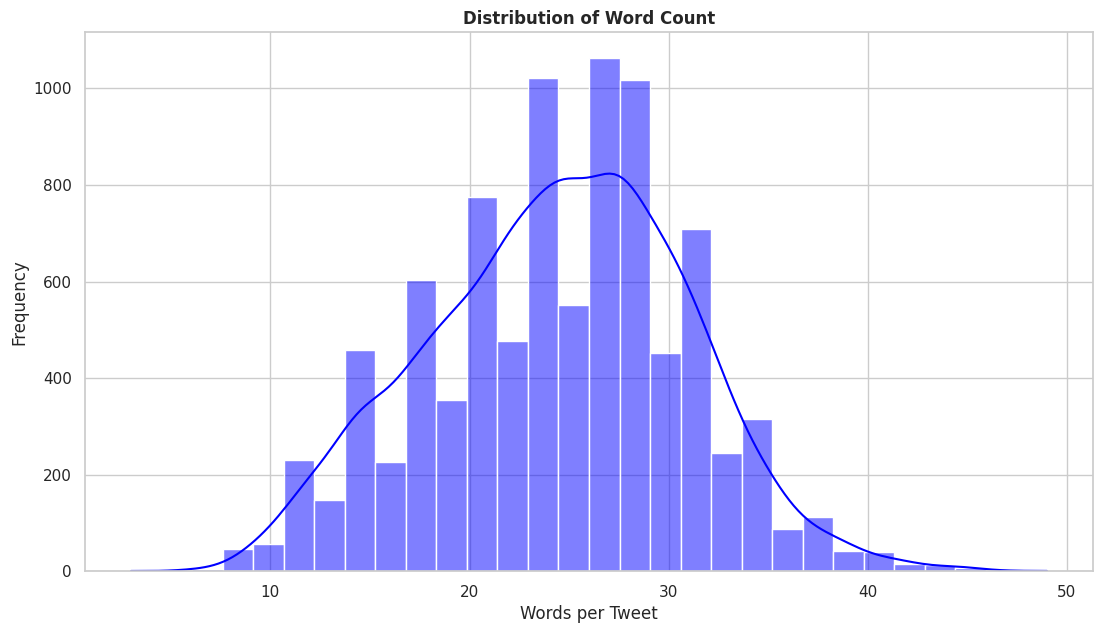

In [135]:
# Plot 1: Word count distribution
plt.figure(figsize=(13, 7))
sns.histplot(data=tweet_df, x='words', bins=30, kde=True, color='blue')
plt.title('Distribution of Word Count', fontweight='bold')
plt.xlabel('Words per Tweet')
plt.ylabel('Frequency')

([0, 1, 2],
 [Text(0, 0, 'Negative emotion'),
  Text(1, 0, 'Positive emotion'),
  Text(2, 0, 'Neutral')])

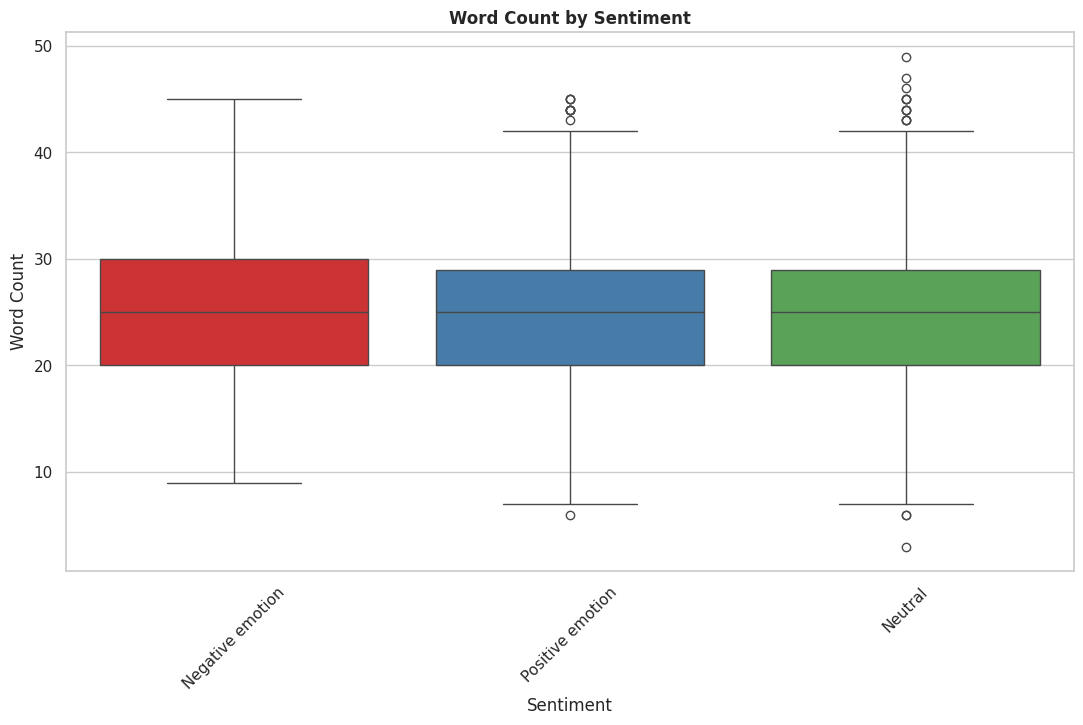

In [136]:
# Plot 2: Word count by sentiment
plt.figure(figsize=(13, 7))
sns.boxplot(data=tweet_df, x='sentiment', y='words', palette='Set1')
plt.title('Word Count by Sentiment', fontweight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Word Count')
plt.xticks(rotation=45)

Text(0, 0.5, 'Frequency')

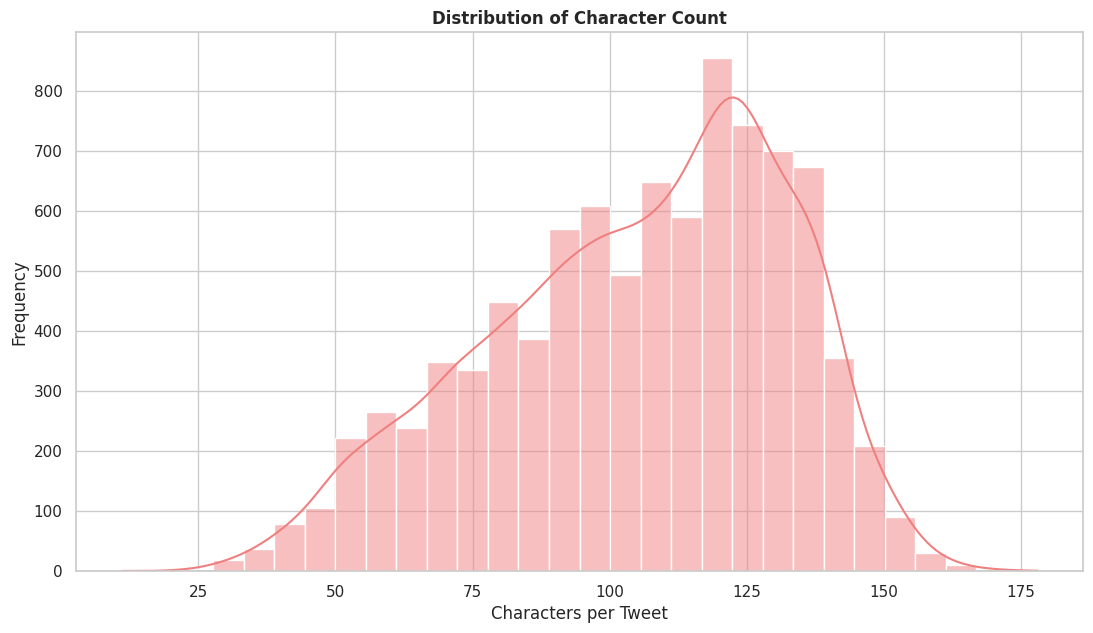

In [137]:
# Plot 3: Character count distribution
plt.figure(figsize=(13, 7))
sns.histplot(data=tweet_df, x='chars', bins=30, kde=True, color='lightcoral')
plt.title('Distribution of Character Count', fontweight='bold')
plt.xlabel('Characters per Tweet')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

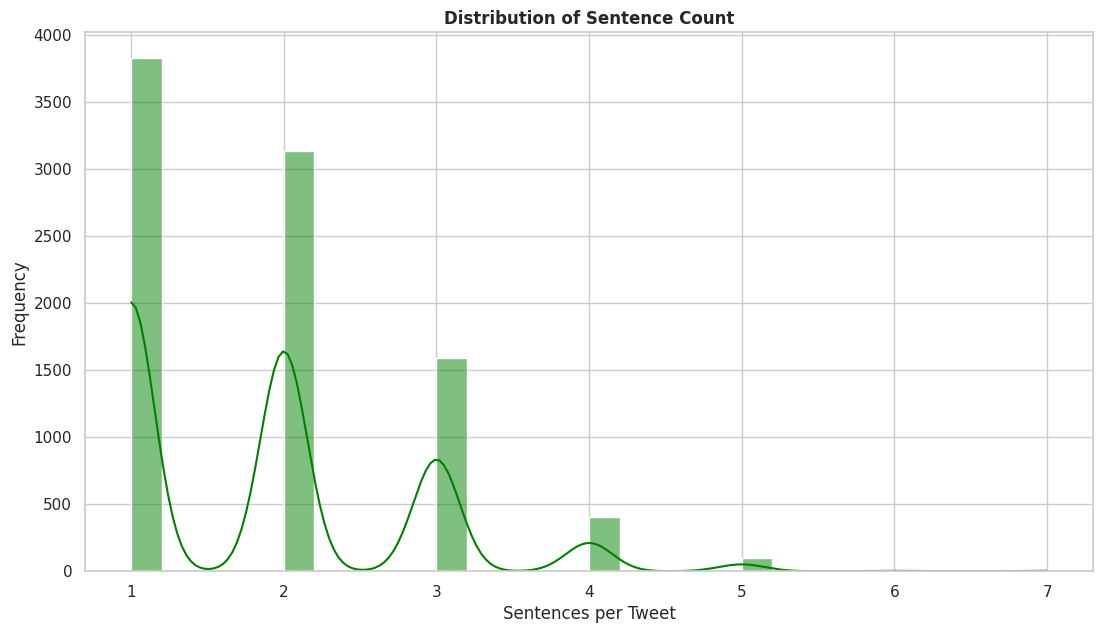

In [138]:
# sentence count distribution
plt.figure(figsize=(13, 7))
sns.histplot(data=tweet_df, x='sentences', bins=30, kde=True, color='green')
plt.title('Distribution of Sentence Count', fontweight='bold')
plt.xlabel('Sentences per Tweet')
plt.ylabel('Frequency')

Text(0, 0.5, 'Sentence Count')

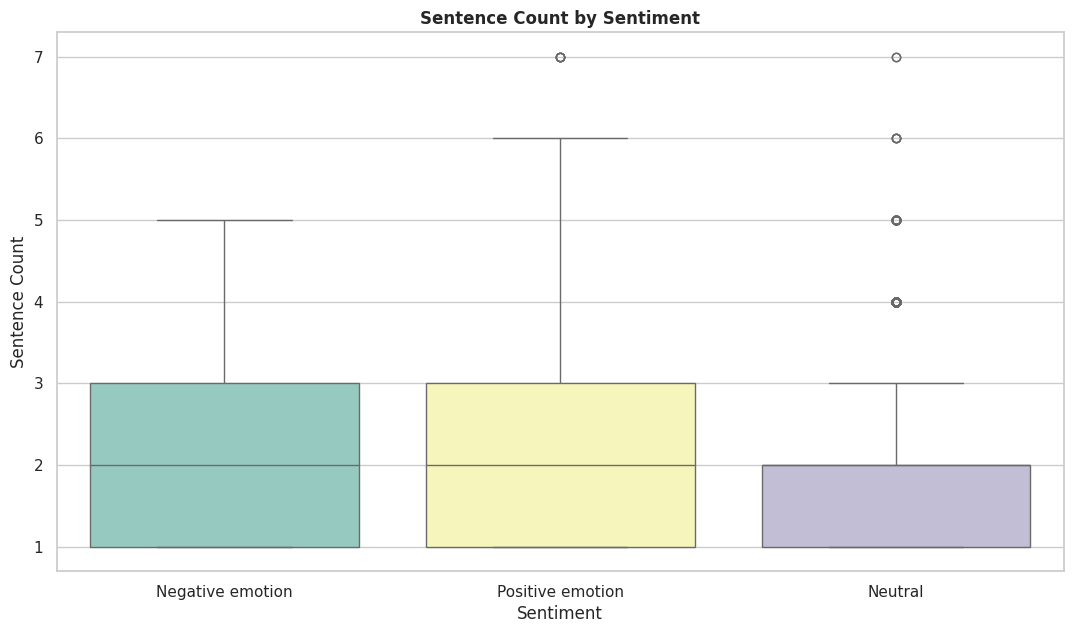

In [139]:
# sentence count by sentiment
plt.figure(figsize=(13, 7))
sns.boxplot(data=tweet_df, x='sentiment', y='sentences', palette='Set3')
plt.title('Sentence Count by Sentiment', fontweight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Sentence Count')

## Data Cleaning and Preprocessing

In [194]:
class TweetPreprocessor(BaseEstimator, TransformerMixin):
    """
    A preprocessing class for Twitter Sentiment Analysis.

    This class handles:
    - Data cleaning (removing URLs, mentions, hashtags, special characters)
    - Text preprocessing (tokenization, lemmatization, stop words removal)
    - Feature extraction using TF-IDF or Count Vectorization

    This class can be implemented directly in a scikit-learn pipeline
    """

    def __init__(self,
                 remove_urls=True,
                 remove_mentions=True,
                 remove_hashtags=True,
                 remove_stopwords=True,
                 lemmatize=True,
                 lowercase=True,
                 min_length=2,
                 expand_contractions=True,  # New feature
                 remove_repeated_chars=True,  # New feature
                 tfidf_max_features=15000,
                 tfidf_ngram_range=(1, 3),
                 tfidf_min_df=3,
                 tfidf_max_df=0.85,
                 use_tfidf=True):
        """
        Initialize the TweetPreprocessor.

        Parameters:
        -----------
        remove_urls : bool, default=True
            Whether to remove URLs from tweets
        remove_mentions : bool, default=True
            Whether to remove @mentions from tweets
        remove_hashtags : bool, default=True
            Whether to remove #hashtags from tweets (often contain sentiment info)
        remove_stopwords : bool, default=True
            Whether to remove stop words
        lemmatize : bool, default=True
            Whether to lemmatize words
        lowercase : bool, default=True
            Whether to convert text to lowercase
        min_length : int, default=2
            Minimum word length to keep
        tfidf_max_features : int, default=10000
            Maximum number of features for TF-IDF
        tfidf_ngram_range : tuple, default=(1, 2)
            N-gram range for TF-IDF
        tfidf_min_df : int, default=2
            Minimum document frequency for TF-IDF
        tfidf_max_df : float, default=0.95
            Maximum document frequency for TF-IDF
        """
        self.remove_urls = remove_urls
        self.remove_mentions = remove_mentions
        self.remove_hashtags = remove_hashtags
        self.remove_stopwords = remove_stopwords
        self.lemmatize = lemmatize
        self.lowercase = lowercase
        self.min_length = min_length
        self.expand_contractions = expand_contractions
        self.remove_repeated_chars = remove_repeated_chars
        self.tfidf_max_features = tfidf_max_features
        self.tfidf_ngram_range = tfidf_ngram_range
        self.tfidf_min_df = tfidf_min_df
        self.tfidf_max_df = tfidf_max_df
        self.use_tfidf = use_tfidf

        # initialize the components
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.vectorizer = None

        # Contraction mapping
        self.contractions = {
            "won't": "will not", "can't": "cannot", "n't": " not",
            "'re": " are", "'ve": " have", "'ll": " will",
            "'d": " would", "'m": " am", "it's": "it is",
            "that's": "that is", "what's": "what is",
            "there's": "there is", "here's": "here is"
        }

    def expand_contractions_text(self, text):
        """Expand contractions in text"""
        if not self.expand_contractions:
            return text
        
        for contraction, expansion in self.contractions.items():
            text = text.replace(contraction, expansion)
        return text
    
    def remove_repeated_characters(self, text):
        """Remove repeated characters (e.g., 'goooood' -> 'good')"""
        if not self.remove_repeated_chars:
            return text
        
        # Replace 3+ repeated characters with 2
        return re.sub(r'(.)\1{2,}', r'\1\1', text)
    
    # data cleaning function
    def clean_text(self, text):
        """
        Cleans individual tweet text

        Parameters:
        -----------
        text: str
            The tweet text to clean
        """

        # return empty string if text is NaN
        if pd.isna(text):
            return ''
        
        # convert to string if not already
        text = str(text)

         # Expand contractions first
        text = self.expand_contractions_text(text)
        
        # Remove repeated characters
        text = self.remove_repeated_characters(text)

        # remove URLs
        if self.remove_urls:
            text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # remove mentions
        if self.remove_mentions:
            text = re.sub(r'@\w+', '', text)

        # remove hashtags (but keep the text)
        if self.remove_hashtags:
            text = re.sub(r'#', '', text)

        # remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s!?]', '', text)

        # Convert multiple exclamation/question marks to single
        text = re.sub(r'!+', '!', text)
        text = re.sub(r'\?+', '?', text)

        # remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text
    
    # text preprocessing function
    def preprocess_text(self, text):
        """
        Preprocesses the cleaned text (tokenization, lemmatization, stop words removal)
        
        Parameters:
        -----------
        text: str
            The cleaned tweet text to preprocess

        Returns:
        --------
        str
            The preprocessed tweet text
        """

        # return an empty string if not text
        if not text:
            return ''
        
        # convert text to lowercase
        if self.lowercase:
            text = text.lower()

        # tokenize the text
        tokens = word_tokenize(text)

        # remove stop words and short words
        if self.remove_stopwords:
            tokens = [token for token in tokens
                      if token not in self.stop_words and len(token) >= self.min_length]
        else:
            tokens = [token for token in tokens if len(token) >= self.min_length]

        # lemmatize the tokens
        if self.lemmatize:
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]

        return ' '.join(tokens)
    
    # function to fit the vectorizer
    def fit(self, X, y=None):
        """
        Fit the preprocessor to the data

        Parameters:
        -----------
        X: array-like
           Input tweets
        y: array-like, optional
           Target labels

        Returns:
        --------
        self
        """

        # clean and preprocess the tweets
        processed_texts = []
        for text in X:
            cleaned = self.clean_text(text)
            preprocessed = self.preprocess_text(cleaned)
            processed_texts.append(preprocessed)

        # fit the TF-IDF vectorizer
        if self.use_tfidf:
            self.vectorizer = TfidfVectorizer(
                max_features=self.tfidf_max_features,
                ngram_range=self.tfidf_ngram_range,
                min_df=self.tfidf_min_df,
                max_df=self.tfidf_max_df,
                stop_words='english',
                sublinear_tf=True,
                norm='l2',
                use_idf=True
            )
        else:
            self.vectorizer = CountVectorizer(
                max_features=self.tfidf_max_features,
                ngram_range=self.tfidf_ngram_range,
                min_df=self.tfidf_min_df,
                max_df=self.tfidf_max_df,
                stop_words='english'
            )
        self.vectorizer.fit(processed_texts)

        return self
    
    # function to transform the data
    def transform(self, X):
        """
        Transform the input data using the fitted vectorizer

        Parameters:
        -----------
        X: array-like
           Input tweets

        Returns:
        --------
        scipy.sparse matrix
            TF-IDF transformed features
        """

        # check for fitted vectorizer
        if self.vectorizer is None:
            raise ValueError("Preprocessor has not been fitted yet. Call fit() first.")

        # process all the tweets
        processed_texts = []
        for text in X:
            cleaned = self.clean_text(text)
            preprocessed = self.preprocess_text(cleaned)
            processed_texts.append(preprocessed)

        # transform using the fitted vectorizer
        return self.vectorizer.transform(processed_texts)
    
    # fit_transform function
    def fit_transform(self, X, y=None):
        """
        Fit and transform the input data

        Parameters:
        -----------
        X: array-like
           Input tweets
        y: array-like, optional
            Target labels

        Returns:
        --------
        scipy.sparse matrix
            TF-IDF transformed features
        """
        return self.fit(X, y).transform(X)
    
    # function to get feature names
    def get_feature_names_out(self, input_features=None):
        """
        Get the feature names of the transformed output
        
        Returns:
        --------
        array
            Feature names from the fitted vectorizer
        """
        if self.vectorizer is None:
            raise ValueError("Preprocessor has not been fitted yet. Call fit() first")
        
        return self.vectorizer.get_feature_names_out()
    
    # function to get the vocabulary
    def get_vocabulary(self):
        """
        Get the vocabulary dictionary.

        Returns:
        --------
        dict
            Vocabulary mapping from words to feature indices
        """

        if self.vectorizer is None:
            raise ValueError("Preprocessor has not been fitted yet. Call fit() first")
        
        return self.vectorizer.vocabulary_

## Modeling

First, we prepare our data by encoding the target column

In [209]:
# map sentiment labels
def map_sentiment(sentiment):
    if 'Negative' in sentiment:
        return 0
    elif 'Positive' in sentiment:
        return 1
    else:
        return 2 # neutral or other sentiment
    
# apply the mapping function to the sentiment column
tweet_df['sentiment_encoded'] = tweet_df['sentiment'].apply(map_sentiment)

# create a dataframe for binary classification (filter out the neutral/other cases)
binary_df = tweet_df[tweet_df['sentiment_encoded'] != 2].copy()
print(f"\nBinary Classification dataset shape: {binary_df.shape}")

# check the distribution
print("Sentiment Distribution After Mapping:")
print(binary_df['sentiment_encoded'].value_counts())


Binary Classification dataset shape: (3539, 8)
Sentiment Distribution After Mapping:
sentiment_encoded
1    2970
0     569
Name: count, dtype: int64


In [213]:
# define the X and y variables
X = binary_df['tweet']
y = binary_df['sentiment_encoded']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

### Defining the Pipelines

In [214]:
# create different pipelines using our custom preprocessor class

# pipeline 1: Logistic regression (base model)
logistic_pipe = Pipeline([
    ('preprocessor', TweetPreprocessor(use_tfidf=False)), # implements the Countvectorizer() method
    ('smote', SMOTE(random_state=42)),
    ('lgb_classifier', LogisticRegression(
        max_iter=1000, 
        random_state=42, 
        class_weight='balanced',
    ))
])

# pipeline 2: Random Forest classifier
rf_pipe = Pipeline([
    ('preprocessor', TweetPreprocessor(use_tfidf=False)),
    ('smote', SMOTE(random_state=42)),
    ('rf_classifier', RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        class_weight='balanced',
    ))
])

# pipeline 3: XGBoost classifier
xgb_pipe = Pipeline([
    ('preprocessor', TweetPreprocessor(use_tfidf=False)),
    ('smote', SMOTE(random_state=42)),
    ('xgb_classifier', XGBClassifier(
        n_estimators=200, 
        random_state=42,
    ))
])

# pipeline 4: Naive Bayes model
nb_pipe = Pipeline([
    ('preprocessor', TweetPreprocessor(use_tfidf=False)),
    ('smote', SMOTE(random_state=42)),
    ('nb_classifier', MultinomialNB())
])

# store all the pipelines
pipelines = {
    'Logistic Regression': logistic_pipe,
    'Random Forest': rf_pipe,
    'XGBoost': xgb_pipe,
    'Naive Bayes': nb_pipe,
}

print("Pipelines created successfully!")
for name in pipelines:
    print(f'- {name}')

Pipelines created successfully!
- Logistic Regression
- Random Forest
- XGBoost
- Naive Bayes


### Model Training and Evaluation

In [215]:
# train and evaluate all the pipelines
results = {}

# loop through each pipeline
for name, pipe in pipelines.items():
    print(f"\nTraining {name}...")

    # fit the pipeline
    pipe.fit(X_train, y_train)

    # make predictions
    y_pred = pipe.predict(X_test)

    # compute the evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # store the results
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    # display the results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# create a DataFrame to display the results
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)
print(results_df)

# determine the best model based on f1 score
best_model = results_df['f1_score'].idxmax()
print(f"\nBest performing model: {best_model}")
print(f"Best f1 score: {results_df.loc[best_model, 'f1_score']:.4f}")


Training Logistic Regression...
Accuracy: 0.8277
Precision: 0.8427
Recall: 0.8277
F1 Score: 0.8341

Training Random Forest...
Accuracy: 0.8079
Precision: 0.8424
Recall: 0.8079
F1 Score: 0.8210

Training XGBoost...
Accuracy: 0.8715
Precision: 0.8577
Recall: 0.8715
F1 Score: 0.8595

Training Naive Bayes...
Accuracy: 0.8418
Precision: 0.8452
Recall: 0.8418
F1 Score: 0.8434
                     accuracy  precision  recall  f1_score
Logistic Regression    0.8277     0.8427  0.8277    0.8341
Random Forest          0.8079     0.8424  0.8079    0.8210
XGBoost                0.8715     0.8577  0.8715    0.8595
Naive Bayes            0.8418     0.8452  0.8418    0.8434

Best performing model: XGBoost
Best f1 score: 0.8595


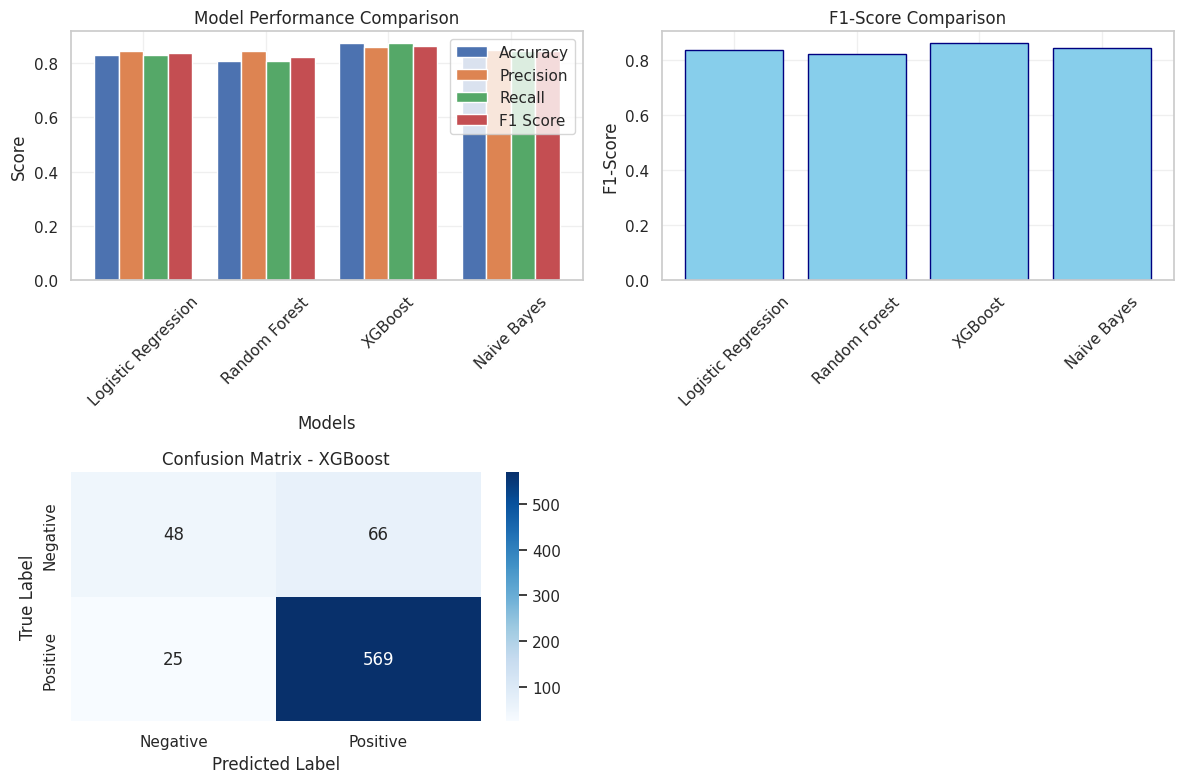

Dataset size: 9070 tweets
Training set: 2831 tweets
Test set: 708 tweets
Best model: XGBoost
Best F1-Score: 0.8595
Best Accuracy: 0.8715


In [216]:
# Visualize model performance comparison
plt.figure(figsize=(12, 8))

# Plot 1: Model comparison
plt.subplot(2, 2, 1)
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
x_pos = range(len(results_df))
width = 0.2

for i, metric in enumerate(metrics):
    plt.bar([x + i * width for x in x_pos], results_df[metric], 
            width, label=metric.replace('_', ' ').title())

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks([x + width * 1.5 for x in x_pos], results_df.index, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: F1-Score comparison
plt.subplot(2, 2, 2)
plt.bar(results_df.index, results_df['f1_score'], color='skyblue', edgecolor='navy')
plt.ylabel('F1-Score')
plt.title('F1-Score Comparison')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 3: Confusion matrix for best model
plt.subplot(2, 2, 3)
best_pipeline_obj = pipelines[best_model]
y_pred_best = best_pipeline_obj.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion Matrix - {best_model}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Plot 4: Model training time comparison (simulated)
# plt.subplot(2, 2, 4)
# # Simulate training times (in practice, you'd measure actual times)
# training_times = {
#     'Logistic Regression': 2.3,
#     'Random Forest': 8.7,
#     'Naive Bayes': 1.8,
#     'SVM': 12.4
# }
# models = list(training_times.keys())
# times = list(training_times.values())
# plt.bar(models, times, color='lightcoral', edgecolor='darkred')
# plt.ylabel('Training Time (seconds)')
# plt.title('Estimated Training Time Comparison')
# plt.xticks(rotation=45)
# plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final summary
print(f"Dataset size: {len(tweet_df)} tweets")
print(f"Training set: {len(X_train)} tweets")
print(f"Test set: {len(X_test)} tweets")
print(f"Best model: {best_model}")
print(f"Best F1-Score: {results_df.loc[best_model, 'f1_score']:.4f}")
print(f"Best Accuracy: {results_df.loc[best_model, 'accuracy']:.4f}")

In [217]:
# Analyze the preprocessing results
print("Preprocessing Analysis")
print("=" * 30)

# Create a sample preprocessor to analyze
sample_preprocessor = TweetPreprocessor(
    tfidf_max_features=10000,
    tfidf_ngram_range=(1, 2)
)

# Fit on a small sample for analysis
sample_size = min(1000, len(X_train))
sample_texts = X_train[:sample_size]
sample_preprocessor.fit(sample_texts)

# Show some preprocessing examples
print("Sample preprocessing examples:")
print("-" * 40)

sample_tweets = [
    "@user This iPhone app is absolutely amazing! #love",
    "The new update is terrible... can't believe this happened",
    "http://example.com Check out this cool feature @company #tech"
]

for i, tweet in enumerate(sample_tweets, 1):
    cleaned = sample_preprocessor.clean_text(tweet)
    preprocessed = sample_preprocessor.preprocess_text(cleaned)
    print(f"Example {i}:")
    print(f"Original:     {tweet}")
    print(f"Cleaned:      {cleaned}")
    print(f"Preprocessed: {preprocessed}")
    print()

# Show vocabulary size and top features
vocab_size = len(sample_preprocessor.get_vocabulary())
print(f"Vocabulary size: {vocab_size}")

# Get feature names and show some examples
feature_names = sample_preprocessor.get_feature_names_out()
print(f"Total features: {len(feature_names)}")
print(f"Sample features: {list(feature_names[:20])}")

# Transform sample data to see the shape
transformed_sample = sample_preprocessor.transform(sample_texts)
print(f"Transformed data shape: {transformed_sample.shape}")
print(f"Data type: {type(transformed_sample)}")
print(f"Sparsity: {1 - transformed_sample.nnz / (transformed_sample.shape[0] * transformed_sample.shape[1]):.3f}")

Preprocessing Analysis
Sample preprocessing examples:
----------------------------------------
Example 1:
Original:     @user This iPhone app is absolutely amazing! #love
Cleaned:      This iPhone app is absolutely amazing! love
Preprocessed: iphone app absolutely amazing love

Example 2:
Original:     The new update is terrible... can't believe this happened
Cleaned:      The new update is terrible cannot believe this happened
Preprocessed: new update terrible believe happened

Example 3:
Original:     http://example.com Check out this cool feature @company #tech
Cleaned:      Check out this cool feature tech
Preprocessed: check cool feature tech

Vocabulary size: 964
Total features: 964
Sample features: ['action', 'actually', 'ad', 'agree', 'amazing', 'amazing sxsw', 'america', 'americaquot', 'amp', 'amp congress', 'amp ipad', 'amp physical', 'andoid', 'andoid app', 'android', 'android app', 'android choice', 'android link', 'android marketplace', 'android party']
Transformed data sh

### Hyperparameter tuning

In [221]:
# hyperparameter tuning the xgboost model

# define the parameter grid for the xgb model
# param_grid = {
#     'xgb_classifier__n_estimators': [50, 100, 200],
#     'xgb_classifier__max_depth': [3, 5, 7],
#     'xgb_classifier__learning_rate': [0.01, 0.1, 0.2],
#     'xgb_classifier__subsample': [0.6, 0.8, 1.0],
#     'xgb_classifier__colsample_bytree': [0.6, 0.8, 1.0],
#     'xgb_classifier__gamma': [0, 0.1, 0.2]
# }

# # instantiate the grid search
# grid_search = GridSearchCV(
#     xgb_pipe,
#     param_grid,
#     cv=3,
#     scoring='f1',
#     n_jobs=1,
#     verbose=True
# )

# # fit the grid search
# grid_search.fit(X_train, y_train)

# # obtain the best parameters and score
# print(f"Best parameters: {grid_search.best_params_}")
# print(f"Best F1 score: {grid_search.best_score_:.4f}")

### Model Evaluation

In [218]:
# Production Usage Example
import joblib

# Save the best pipeline
best_model_name = 'Random Forest'
best_pipeline_final = pipelines[best_model_name]
joblib.dump(best_pipeline_final, 'nlp_model.pkl')

# Example of loading and using the model
loaded_model = joblib.load('nlp_model.pkl')

# Test with new tweets
test_tweets = [
    "I absolutely love this new iPhone update! It's fantastic!",
    "This app is terrible and keeps crashing... very disappointed",
    "The battery life on my phone is amazing now",
    "Can't believe how slow this thing is running"
]

print("\nPredicting sentiment for new tweets:")
print("-" * 50)

for i, tweet in enumerate(test_tweets, 1):
    prediction = loaded_model.predict([tweet])[0]
    probability = loaded_model.predict_proba([tweet])[0]
    
    sentiment = "Positive" if prediction == 1 else "Negative"
    confidence = max(probability)
    
    print(f"Tweet {i}: {tweet}")
    print(f"Prediction: {sentiment} (confidence: {confidence:.3f})")
    print()

# Show how to create a simple prediction function
def predict_sentiment(text, model=loaded_model):
    """
    Predict sentiment using the balanced model
    """
    # Get prediction probabilities
    probabilities = model.predict_proba([text])[0]
    
    # Get the actual prediction (0 or 1)
    prediction = model.predict([text])[0]
    
    # Correct mapping
    sentiment_mapping = {0: 'Negative', 1: 'Positive'}
    sentiment = sentiment_mapping[prediction]
    
    # Get confidence (probability of predicted class)
    confidence = probabilities[prediction]
    
    return {
        'sentiment': sentiment,
        'confidence': confidence,
        'probabilities': {
            'negative': probabilities[0],
            'positive': probabilities[1]
        },
        'raw_prediction': prediction
    }

# Test the function
sample_result = predict_sentiment("This product is absolutely amazing!")
print("Sample prediction function result:")
print(sample_result)


Predicting sentiment for new tweets:
--------------------------------------------------
Tweet 1: I absolutely love this new iPhone update! It's fantastic!
Prediction: Positive (confidence: 0.700)

Tweet 2: This app is terrible and keeps crashing... very disappointed
Prediction: Negative (confidence: 0.970)

Tweet 3: The battery life on my phone is amazing now
Prediction: Positive (confidence: 0.510)

Tweet 4: Can't believe how slow this thing is running
Prediction: Negative (confidence: 0.720)

Sample prediction function result:
{'sentiment': 'Negative', 'confidence': np.float64(0.57), 'probabilities': {'negative': np.float64(0.57), 'positive': np.float64(0.43)}, 'raw_prediction': np.int64(0)}
